# Notebook Intro:

In this notebook, I use my cleaned training data, then sort the features into four categories based on the data types found in the data dictioary.  These include continuous, nominal, discrete, and ordinal features.

**Note: This notebook deals primarily with nominal features (also known as categorical features).
See notebook 4 for addressing ordinal features, and notebook 5 for addressing continuous and discrete features.**

In this notebook I first create a workflow for looking at one categorical variable - turning it into dummy columns,  reviewing the r^2 correlation wrt Sale Price for each dummy column, then selecting only columns with r^2 values over .2.

I then use this workflow as the basis for a set of functions so that I can turn all the categorical variables into dummy columns and select only the dummy columns for the whole set with r^2 values greater than .2.

I also work on implementing a check so that I can verify I'm not selecting all dummy columns for a given feature (I don't drop a dummy intentionally when doing the split, but I verified that at least one dummy column was dropped for a given feature so that the model is not overdetermined.

I do a linear regression on the selected dummy columns, but have a low cross-val score, so I move on to try other models and do not use the test data with this.

Finally, I export the file with dummy columns for use in other notebooks.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

In [17]:
# import cleaned training data
filepath = '../datasets/interim_files/train_clean.csv'

df = pd.read_csv(filepath)

## Sort Features into 4 types

These types are per the data dictionary:

* **continuous** features do not need to be dummies

* **nominal** features need dummies

* **discrete** features should be reviewed - likely remain as-is

* **ordinal** features need to be converted using the dictionary and ranking system

In [18]:
# continuous features - per the data dictionary
continuous_features = ['Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area','Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area','Misc Val']

# nominal features - per the data dictionary
nominal_features = ['PID','MS SubClass','MS Zoning','Street','Alley','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','Bldg Type','House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air','Garage Type','Misc Feature','Sale Type']

# discrete features 
discrete_features = ['Year Built','Year Remod/Add','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Yr Blt','Garage Cars','Mo Sold','Yr Sold']

# Ordinal Features
ordinal_features = ['Lot Shape','Utilities','Land Slope','Overall Qual','Overall Cond','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC','Electrical','Kitchen Qual','Functional','Fireplace Qu','Garage Finish','Garage Qual','Garage Cond','Paved Drive','Pool QC','Fence']

In [19]:
#check to confirm all columns dropped except ID and Sale Price

df.drop(columns = continuous_features).drop(columns = nominal_features).drop(columns = discrete_features).drop(columns = ordinal_features).columns

Index(['Id', 'SalePrice'], dtype='object')

## Explore Nominal Features (i.e. categorical features with no ranking)

First review how to explore one feature, then can work on creating a function to do this for all features where it makes sense

In [20]:
# see how many values are in a given feature

df['MS SubClass'].value_counts()

20     758
60     385
50     198
120    130
30     101
70      89
160     88
80      85
90      75
190     46
85      28
75      16
180     11
45      11
40       4
150      1
Name: MS SubClass, dtype: int64

In [21]:
#get dummmies for a given column

df_dum = pd.get_dummies(df['MS SubClass'],drop_first=True)

In [22]:
# concatenate the dummies with the Sale Price column

df_dum_concat = pd.concat([df['SalePrice'],df_dum], axis=1)

In [23]:
# calculate the correlation coefficient for the dummmies

df_dum_concat.corr()['SalePrice']

SalePrice    1.000000
30          -0.248966
40          -0.034741
45          -0.060282
50          -0.181563
60           0.357469
70          -0.074588
75           0.027040
80          -0.029861
85          -0.039672
90          -0.103142
120          0.102744
150         -0.009132
160         -0.114372
180         -0.066541
190         -0.109062
Name: SalePrice, dtype: float64

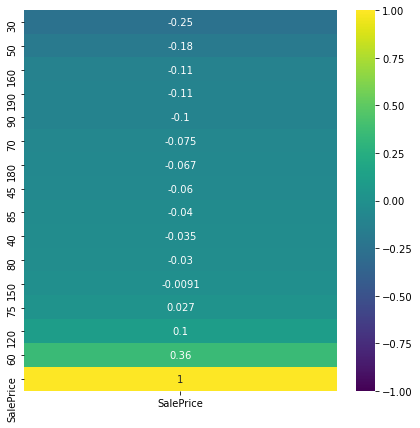

In [24]:
# plot the correlation coefficient

plt.figure(figsize=(7,7))

sns.heatmap(df_dum_concat.corr()[['SalePrice']].sort_values('SalePrice'),
           annot=True,
           vmin=-1,
           vmax=1,
           cmap='viridis');

In [25]:
# calculates the correlation coefficient for all dummy variables and returns the variables 
# with the 5 highest correlations (absolute value) 
# as well as the saleprice for a check to make sure it's 1

np.abs(df_dum_concat.corr()[['SalePrice']]).sort_values('SalePrice', ascending=False)[0:6]

,SalePrice
SalePrice,1.000000
60,0.357469
30,0.248966
50,0.181563
160,0.114372
190,0.109062


In [26]:
# returns an index of the top 5, so can go back to the correlation coefficient 
# and retrieve the actual value rather than the absolute values

index_of_top5 = np.abs(df_dum_concat.corr()[['SalePrice']]).sort_values('SalePrice', ascending=False)[0:6].index

final_5_categories = df_dum_concat.corr()[['SalePrice']].loc[index_of_top5]

In [27]:
final_5_categories.rename(columns = {'SalePrice':'MS SubClass'},inplace = True)

In [28]:
len(df['MS SubClass'].unique())

16

## Create Function to Explore Nominal Features 

(does what I did in previous section)

In [29]:
# create function that returns a dataframe with the categories with the top 5 correlation coefficients per category

def feature_function(df, feature, target):

    # see how many values are in a given feature
    Value_counts_df = df[feature].value_counts()
    num_values = len(df[feature].unique())
    
    num_values = [feature,num_values]
    num_values = pd.DataFrame(data = [num_values[1]], columns = [num_values[0]])

    #get dummmies for a given column
    df_dum = pd.get_dummies(df[feature],drop_first=True, prefix=feature)

    # concatenate the dummies with the Sale Price column
    df_dum_concat = pd.concat([df[target],df_dum], axis=1)

    # returns an index of the top 5, so can go back to the correlation coefficient 
    # and retrieve the actual value rather than the absolute values

    index_of_top5 = np.abs(df_dum_concat.corr()[[target]]).sort_values(target, ascending=False)[0:6].index

    final_5_categories = df_dum_concat.corr()[[target]].loc[index_of_top5]
    final_5_categories.rename(columns = {target:feature},inplace = True)
                                                                           
    return final_5_categories, num_values 

In [30]:
final_5, num_values = feature_function(df,'MS Zoning','SalePrice')

In [31]:
final_5

,MS Zoning
SalePrice,1.000000
MS Zoning_RM,-0.279909
MS Zoning_RL,0.233617
MS Zoning_C (all),-0.126575
MS Zoning_FV,0.105029
MS Zoning_I (all),-0.034637


In [32]:
nm = num_values

In [33]:
bs = num_values

In [34]:
pd.concat([nm,bs], axis = 1)

,MS Zoning,MS Zoning
0,7,7


### Functions Part 2
Now that I have a data frame for a given feature, I want to be able to only return dummy variables that have a correlation coefficient over a given threshold

In [35]:
### Function to analyze features that could be dummies

def final_f(df,feature,target,threshold):
    final_f, num_values = feature_function(df, feature, target)
    final2 = final_f[np.abs(final_f[feature]) > threshold]
    
    return final2

#function to return just num_values

def final_number(df,feature,target):
    final_f, num_values = feature_function(df, feature, target)
    
    return num_values

### Functions Part 3

No I want to have one combined dataframe so it's easy to review which dummy variables for a given feature are ones I care about

In [36]:
# Function to create final dataframe of dummies, based on a dataframe, list of features interested in, a target column, and threshold for a correlation coefficient
# Column names are the feature names, the index names are the particular values for a feature (dummy column names)

def combine_dfs(df,feature_list,target,threshold):
    nominal_features_correlations = [final_f(df,feature,target,threshold) for feature in feature_list]
    cleaned_dataframe = [df[1:] for df in nominal_features_correlations if len(df) > 1] 
    combined_df = pd.concat(cleaned_dataframe, join='outer')
    
    #verify number of aspects of a feature are kept per nominal feature
    #len_of_each_dataframe = [[df.columns,len(df)] for df in nominal_features_correlations]
    len_of_each_dataframe = [pd.DataFrame(data = [len(df)-1], columns = [df.columns]) for df in nominal_features_correlations]
    combined_lengths = pd.concat(len_of_each_dataframe, axis = 1)
    combined_lengths.rename(index = {0:'num_used_values'}, inplace = True)
    
    
    num_values_perfeature = [final_number(df,feature,target) for feature in feature_list]
    num_values_df = pd.concat(num_values_perfeature, axis = 1)
    num_values_df.rename(index = {0:'num_overall_values'}, inplace = True)
    
    #compared_values =pd.concat([combined_lengths,num_values_df], axis = 0) 
    compared_values = 0
    
    return combined_df, num_values_df, combined_lengths, compared_values

In [37]:
combined, num_value_df, combined_lengths, compared_values = combine_dfs(df,nominal_features,'SalePrice',.2)

In [38]:
num_value_df.rename(index = {0:'num_overall_values'}, inplace = True)

In [39]:
num_value_df

,PID,MS SubClass,MS Zoning,Street,Alley,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,...,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Heating,Central Air,Garage Type,Misc Feature,Sale Type
num_overall_values,2026,16,7,2,3,4,5,28,9,8,...,6,15,15,4,6,5,2,7,6,9


In [40]:
combined_lengths.rename(index = {0:'num_used_values'}, inplace = True)

In [41]:
combined_lengths

,PID,MS SubClass,MS Zoning,Street,Alley,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,...,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Heating,Central Air,Garage Type,Misc Feature,Sale Type
num_used_values,0,2,2,0,0,1,0,4,0,0,...,0,1,1,3,2,0,1,4,0,2


#### I compared the entries in the num_overall values which includes how many unique values are in each nominal feature to how many values I selected for each feature when looking at ones that have an r2 value > .2 (after turning them into dummies).  I verified that I'm not pulling all values for any given feature, so my model will be ok.

In [49]:
# this data frame shows the r2 value for each dummy column I selected, 
# organized by nominal category across the top, and the index uses 
# the combination of the nominal feature and the particular value for the dummy column

combined

,MS SubClass,MS Zoning,Land Contour,Neighborhood,House Style,Roof Style,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Central Air,Garage Type,Sale Type
MS SubClass_60,0.357469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MS SubClass_30,-0.248966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MS Zoning_RM,NaN,-0.279909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MS Zoning_RL,NaN,0.233617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Land Contour_HLS,NaN,NaN,0.214018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neighborhood_NridgHt,NaN,NaN,NaN,0.445931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neighborhood_NoRidge,NaN,NaN,NaN,0.266658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neighborhood_StoneBr,NaN,NaN,NaN,0.260055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neighborhood_OldTown,NaN,NaN,NaN,-0.208036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
House Style_2Story,NaN,NaN,NaN,NaN,0.20317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
combined.index

Index(['MS SubClass_60', 'MS SubClass_30', 'MS Zoning_RM', 'MS Zoning_RL',
       'Land Contour_HLS', 'Neighborhood_NridgHt', 'Neighborhood_NoRidge',
       'Neighborhood_StoneBr', 'Neighborhood_OldTown', 'House Style_2Story',
       'Roof Style_Hip', 'Roof Style_Gable', 'Exterior 1st_VinylSd',
       'Exterior 2nd_VinylSd', 'Mas Vnr Type_None', 'Mas Vnr Type_Stone',
       'Mas Vnr Type_BrkFace', 'Foundation_PConc', 'Foundation_CBlock',
       'Central Air_Y', 'Garage Type_Detchd', 'Garage Type_Attchd',
       'Garage Type_none', 'Garage Type_BuiltIn', 'Sale Type_New',
       'Sale Type_WD '],
      dtype='object')

In [54]:
len(combined)

26

In [62]:
combined.columns

Index(['MS SubClass', 'MS Zoning', 'Land Contour', 'Neighborhood',
       'House Style', 'Roof Style', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Foundation', 'Central Air', 'Garage Type',
       'Sale Type'],
      dtype='object')

In [55]:
df_long = pd.get_dummies(df, columns = combined.columns)

In [56]:
df_to_review = df_long[combined.index]

In [57]:
#export dummy columns with r2 over.2
filepath = '../datasets/interim_files/dummiesbest.csv'

df_to_review.to_csv(filepath, index=False)

# check on linear regression with the selected dummy columns alone

In [58]:
X = df_to_review
y = df['SalePrice']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [60]:
lr = LinearRegression()

In [61]:
cross_val_score(lr,X_train,y_train).mean()

0.5980611121314231

In [ ]:
# the cross val score is low, so I will continue searching for more features to analyze

# Notebook Summary:

In this notebook, I use my cleaned training data, then sort the features into four categories based on the data types found in the data dictioary.  These include continuous, nominal, discrete, and ordinal features.

**Note: This notebook deals primarily with nominal features (also known as categorical features).
See notebook 4 for addressing ordinal features, and notebook 5 for addressing continuous and discrete features.**

In this notebook I first create a workflow for looking at one categorical variable - turning it into dummy columns,  reviewing the r^2 correlation wrt Sale Price for each dummy column, then selecting only columns with r^2 values over .2.

I then use this workflow as the basis for a set of functions so that I can turn all the categorical variables into dummy columns and select only the dummy columns for the whole set with r^2 values greater than .2.

I also work on implementing a check so that I can verify I'm not selecting all dummy columns for a given feature (I don't drop a dummy intentionally when doing the split, but I verified that at least one dummy column was dropped for a given feature so that the model is not overdetermined.

I do a linear regression on the selected dummy columns, but have a low cross-val score, so I move on to try other models and do not use the test data with this.

Finally, I export the file with dummy columns for use in other notebooks.